In [1]:
import os
import numpy as np
import torch
import scipy
from radioNN.data.loader import AntennaDataset
from radioNN.data.transforms import sph2cart
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from radioNN.process_network import NetworkProcess
from radioNN.networks.antenna_fc_network import AntennaNetworkFC
from view_scalars import thin_or_not
from view_scalars import get_fluences0, get_fluences1, get_lateral_distance
from scipy import integrate
from tqdm.auto import tqdm
radio_data_path = "/home/pranav/work-stuff-unsynced/radio_data"
input_data_file = os.path.join(radio_data_path, "input_data.npy")
input_meta_file = os.path.join(radio_data_path, "meta_data.npy")
antenna_pos_file = os.path.join(radio_data_path, "antenna_pos_data.npy")
output_meta_file = os.path.join(radio_data_path, "output_meta_data.npy")
#output_file = os.path.join(radio_data_path, "output_gece_data.npy")
output_file = os.path.join(radio_data_path, "output_vBvvB_data.npy")
dataset = AntennaDataset(
    input_data_file,
    input_meta_file,
    antenna_pos_file,
    output_meta_file,
    output_file,
    mmap_mode='r',
    one_shower=33,
    # return_fluence=False,
    # percentage=0.01,
)
process = NetworkProcess(
    model_class=AntennaNetworkFC,
    # one_shower=one_shower,
    percentage=0.1,
    batch_size=8,
    wb=False,
)
process.output_channels = 2
#process.model = torch.load(
    # "/home/pranav/MEGA/work-stuff/radio_nn/runs/2309Sep26Tue_155429/SavedModel",
    # "/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May14Tue_172854/SavedModel",
   #"/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May18Sat_030851/SavedModel",
 #   "/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May24Fri_145354/SavedModel",
    #"/home/pranav/MEGA/work-stuff/radio_nn/runs/2406Jun10Mon_144306/SavedModel",
  #  map_location=torch.device("cpu"),
#)
#process.model.eval()

model_name = "2405May24Fri_145354" #awesome model but only zenith 45-55
#model_name = "2406Jun10Mon_144306"
#model_name = "2406Jun20Thu_200714"
model_name = "2407Jul29Mon_213725" #decent model
process.model = AntennaNetworkFC(2)
state_checkpoint = torch.load(
    f"/home/pranav/MEGA/work-stuff/radio_nn/runs/{model_name}/SavedState",
)
process.model.load_state_dict(state_checkpoint['model_state_dict'])
process.model.eval()
def make_table(input_meta):
    """
    Meta Data format:
    index 0: Sim number
    index 1: Cos(Zenith Angle)
    index 2: X_max
    index 3: density at X_max
    index 4: height at X_max
    index 5: E_em
    index 6: sin(geomagnetic_angle)
    index 7: B inclination
    index 8: B declination
    index 9: B strength
    index 10: primary particle
    index 11: primary energy
    index 12: Azimuthal angle
    """
    return {
        "Sim number": input_meta[0],
        "Zenith": np.rad2deg(np.arccos(input_meta[1])),
        "X_max": input_meta[2]*700,
        "density at X_max": input_meta[3],
        "height at X_max": input_meta[4]*700*1e3,
        "E_em": np.exp(input_meta[5]*20),
        "sin(geomagnetic_angle)": input_meta[6],
        "B inclination": input_meta[7],
        "B declination": input_meta[8],
        "B strength": input_meta[9],
        "primary particle": input_meta[10],
        "primary energy": np.exp(input_meta[11]),
        "Azimuth": np.rad2deg(input_meta[12]),
    }

/home/pranav/.conda/envs/pytorch3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using the data from /home/pranav/work-stuff-unsynced/radio_data in cpu with memmap mode: r using 0.1% of data
Total showers after filter 58185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 1198.61it/s]

2
Using <class 'radioNN.networks.antenna_fc_network.AntennaNetworkFC'>


In [2]:
def make_event_str(input_meta):
    return '\n'.join((
    r'$\theta=%.2f$' % (np.rad2deg(np.arccos(input_meta[1])),),
    r'$X_{max}=%.2f$' % (input_meta[2]*700, ),
    r'$E_0=%.2e$' % (np.exp(input_meta[11]),)))

In [3]:
def box_hist(X, Y,bins = 8, xlabel='X', ylabel='Y'):
    import matplotlib.ticker as ticker
    # Use numpy.histogram for binning
    counts, bin_edges = np.histogram(X, bins=bins)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    width = (np.max(bin_edges) - np.min(bin_edges))/(bins*3)
    # Prepare a dictionary to store data for violin plots
    box_data = []
    for i, center in enumerate(bin_centers):
      # Filter data points within the current bin range
        bin_data = [y for x, y in zip(X, Y) if bin_edges[i] <= x < bin_edges[i+1]]
        box_data.append(bin_data)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10,7))
    ax.boxplot(box_data, showfliers=False, positions=bin_centers, widths=width)  # Format bin center
    h = ax.hist2d(X,Y, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0.1), np.percentile(raderr,99.1)]], density=True, cmap='Reds')
    plt.colorbar(h[3], ax=ax, cmap='Reds')
    ax.xaxis.set_major_formatter('{x:0.1f}')
    # Overall plot customizations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [26]:
def bias_resolution(X, Y,bins = 8, xlabel='X', ylabel='Y'):
    import matplotlib.ticker as ticker
    # Use numpy.histogram for binning
    counts, bin_edges = np.histogram(X, bins=bins)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Prepare a dictionary to store data for violin plots
    box_data = []
    for i, center in enumerate(bin_centers):
      # Filter data points within the current bin range
        bin_data = [y for x, y in zip(X, Y) if bin_edges[i] <= x < bin_edges[i+1]]
        box_data.append(bin_data)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10,7))
    mean_array = np.zeros((*bin_centers.shape,4))
    std_array = np.zeros((*bin_centers.shape,4))
    for i, dd in enumerate(box_data):
        dd = np.array(dd)
        a = (dd,)#[dd < np.percentile(dd,99)],)
        if len(a[0]) < 2:
            continue
        
        mean_boot = scipy.stats.bootstrap(a, np.mean, method='percentile')
        std_boot = scipy.stats.bootstrap(a, np.std, method='percentile')
        mean_array[i,0] = np.mean(a)
        mean_array[i,1] = mean_boot.confidence_interval.low
        mean_array[i,2] = mean_boot.confidence_interval.high
        mean_array[i,3] = mean_boot.standard_error
        std_array[i, 0] = np.std(a)
        std_array[i, 1] = std_boot.confidence_interval.low
        std_array[i, 2] = std_boot.confidence_interval.high
        std_array[i, 3] = std_boot.standard_error
    print(mean_array[:,0])
    print(mean_array[:,1:].T.shape)
    print(bin_centers.shape)
    ax.errorbar(bin_centers, mean_array[:,0], yerr=mean_array[:,3].T, label='bias', fmt='o', barsabove=True)
    ax.errorbar(bin_centers, std_array[:,0], yerr=std_array[:,3].T,label='resolution', fmt='o', barsabove=True)
    ax.xaxis.set_major_formatter('{x:2.0f}')
    # Overall plot customizations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.legend()

In [5]:

def radiation_energy(real, pos, meta, sim, inp_meta):
    mask = np.abs(pos[:,0]<10) & (pos[:,1]>0)
    fluence = get_fluences0(real[mask], pos[mask], meta[mask]) + get_fluences1(real[mask], pos[mask], meta[mask])
    distance = get_lateral_distance(real[mask], pos[mask], meta[mask])
    sortind = np.argsort(distance)
    flu = fluence[sortind]
    d = distance[sortind]
    return integrate.trapz(flu*d,d)*2*np.pi

In [6]:

def footprint(real, pos, meta, sim, inp_meta, index=0):
    if index == 0:
        from view_scalars import get_fluences0 as sc_fn
    elif index == 1:
        from view_scalars import get_fluences1 as sc_fn
    elif index == 2:
        from view_scalars import thin_or_not as sc_fn
    else:
        from view_scalars import get_polarity as sc_fn
    from scipy.interpolate import RBFInterpolator
    fig, ax = plt.subplot_mosaic("ABCD", figsize=(20, 10), gridspec_kw={"width_ratios": [49, 1, 49, 1]})
    x_pos = pos[:, 0]
    y_pos = pos[:, 1]
    xs = np.linspace(np.nanmin(x_pos), np.nanmax(x_pos), 100)
    ys = np.linspace(np.nanmin(y_pos), np.nanmax(y_pos), 100)
    xx, yy = np.meshgrid(xs, ys)
    # points within a circle
    in_star = np.array(xx**2 + yy**2 <= np.nanmax(x_pos**2 + y_pos**2))
    scalar1 = sc_fn(real, pos, meta)
    scalar2 = sc_fn(sim, pos, meta)
    axeses = ["A", "B", "C", "D"]
    for axis_id in [0, 2]:
        axis = axeses[axis_id]
        if axis == "A":
            scalar = scalar1
            name = "CoREAS"
        else:
            scalar = scalar2
            name = "Neural Network"
        interp_func = RBFInterpolator(list(zip(x_pos, y_pos)), scalar, kernel="quintic")
        fp_interp = np.where(
            in_star.flatten(),
            interp_func(np.array([xx, yy]).reshape(2, -1).T),
            np.nan,
        ).reshape(100, 100)
        pcm = ax[axis].pcolormesh(
            xx,
            yy,
            fp_interp,
            vmin=np.min([np.min(scalar1), np.min(scalar2)]),
            vmax=np.max([np.max(scalar1), np.max(scalar2)]),
            cmap="inferno",
            shading="gouraud",
        )  # use shading="gouraud" to make it smoother

        # _cbi.set_label(self._skey, fontsize=20)
        ax[axis].set_ylabel("vvB / m")
        ax[axis].set_xlabel("vB / m")
        ax[axis].set_facecolor("white")
        ax[axis].set_aspect(1)
        ax[axis].set_xlim(-100, 100)
        ax[axis].set_ylim(-100,100)
        ax[axis].set_title(name)
        ax[axis].scatter(
            x_pos,
            y_pos,
            edgecolor="w",
            facecolor="none",
            s=5,
            lw=1.0,
        )
        _cbi = fig.colorbar(
                pcm, pad=0.5, cax=ax[axeses[axis_id + 1]], aspect=10, format=lambda x, _: f"{x:.1e}"
        )
    plt.show()

In [7]:
N = 2000
rad_energy = np.full((N,2), np.nan)
meta_list = np.full((N,13), np.nan)
for i, choice in tqdm(enumerate(np.random.choice(np.unique(np.arange(26387)), size=N)), total=N):
    data_ = dataset.data_of_single_shower(choice)
    inp_meta_, pos_, meta_, real_ = data_[1], data_[2], data_[3], data_[4]
    sph2cart(pos_)
    try:
        sim_ = process.pred_one_shower(choice)[1].numpy()
    except RuntimeError:
        tqdm.write(f"Skipping {choice}")
        pass
    #footprint(real_, pos_, meta_, sim_, data_[1])
    #footprint(sim_, pos_, meta_, sim_, data_[1])
    #footprint(real_, pos_, meta_, sim_, data_[1], index=1)
    #footprint(sim_, pos_, meta_, sim_, data[1], index=1)
    real_rad1d = radiation_energy(real_, pos_, meta_, sim_, inp_meta_)
    sim_rad1d = radiation_energy(sim_, pos_, meta_, sim_, inp_meta_)
    rad_energy[i,0]  = real_rad1d
    rad_energy[i,1] = sim_rad1d
    rel_rad_error = (real_rad1d - sim_rad1d)/real_rad1d
    if np.abs(rel_rad_error) > 5:
        tqdm.write(str(make_table(inp_meta_)))
        #footprint(real_, pos_, meta_, sim_, data_[1], index=0)
        #footprint(real_, pos_, meta_, sim_, data_[1], index=1)
    meta_list[i] = inp_meta_

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/pranav/MEGA/work-stuff/radio_nn/radioNN/data/transforms.py:53: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837265408/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  meta_data.T[2] /= 700


{'Sim number': 39724.0, 'Zenith': 33.9867, 'X_max': 1030.8723092079163, 'density at X_max': 1e-09, 'height at X_max': 160124.3570446968, 'E_em': 9.319465915691872e+17, 'sin(geomagnetic_angle)': 0.9975483, 'B inclination': -0.63053364, 'B declination': 0.0, 'B strength': 24.113268, 'primary particle': 14.0, 'primary energy': 1.0783308e+18, 'Azimuth': 4.329844}
{'Sim number': 92624.0, 'Zenith': 40.964897, 'X_max': 1057.5877904891968, 'density at X_max': 1e-09, 'height at X_max': 235770.9378004074, 'E_em': 9.663605786779317e+16, 'sin(geomagnetic_angle)': 0.9581647, 'B inclination': -0.63286024, 'B declination': 0.0, 'B strength': 24.0286, 'primary particle': 14.0, 'primary energy': 1.2087879e+17, 'Azimuth': 3.4498682}
{'Sim number': 43724.0, 'Zenith': 44.804996, 'X_max': 1132.9991459846497, 'density at X_max': 1e-09, 'height at X_max': 221967.57197380066, 'E_em': 1.2627052039883861e+17, 'sin(geomagnetic_angle)': 0.9898042, 'B inclination': -0.63067293, 'B declination': 0.0, 'B strength': 

/tmp/ipykernel_1359674/700345299.py:21: RuntimeWarning: invalid value encountered in scalar divide
  rel_rad_error = (real_rad1d - sim_rad1d)/real_rad1d


Skipping 2150
{'Sim number': 11122.0, 'Zenith': 34.0641, 'X_max': 1004.1422247886658, 'density at X_max': 1e-09, 'height at X_max': 209101.7484664917, 'E_em': 8.102732088270007e+17, 'sin(geomagnetic_angle)': 0.8111163, 'B inclination': -0.62926203, 'B declination': 0.0, 'B strength': 24.152649, 'primary particle': 14.0, 'primary energy': 9.454939e+17, 'Azimuth': 2.9249797}
{'Sim number': 40525.0, 'Zenith': 44.7175, 'X_max': 1176.5186667442322, 'density at X_max': 1e-09, 'height at X_max': 186266.30008220673, 'E_em': 3.302986788388309e+17, 'sin(geomagnetic_angle)': 0.99222493, 'B inclination': -0.6305254, 'B declination': 0.0, 'B strength': 24.10879, 'primary particle': 14.0, 'primary energy': 3.9197538e+17, 'Azimuth': 3.6862922}
Skipping 10203
Skipping 5046
Skipping 10067
{'Sim number': 64324.0, 'Zenith': 42.946396, 'X_max': 1098.2423424720764, 'density at X_max': 1e-09, 'height at X_max': 225449.2312669754, 'E_em': 2.6663819914672867e+17, 'sin(geomagnetic_angle)': 0.99333566, 'B incli

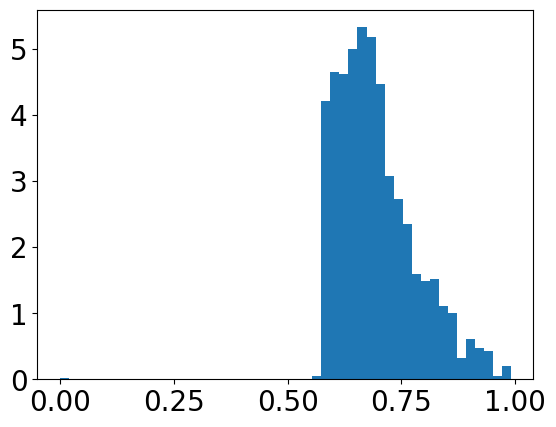

In [8]:
plt.hist(meta_list[:, 1], bins=50, density=True);

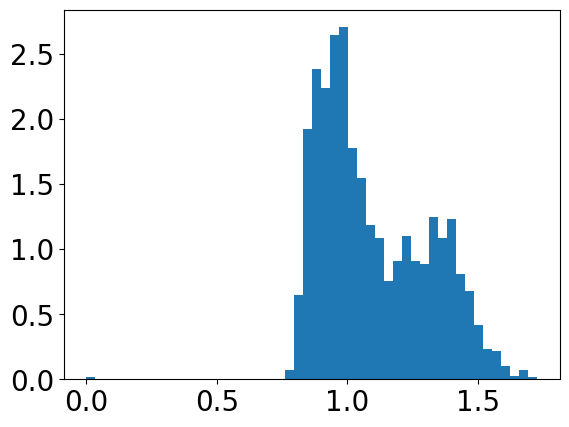

In [9]:
plt.hist(meta_list[:, 2],  bins=50, density=True);

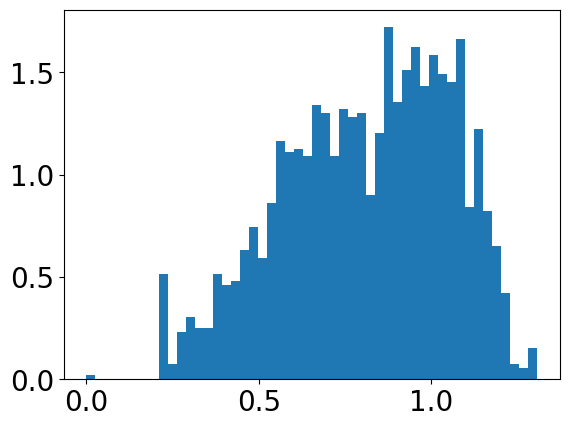

In [10]:
plt.hist(meta_list[:, 4],  bins=50, density=True);

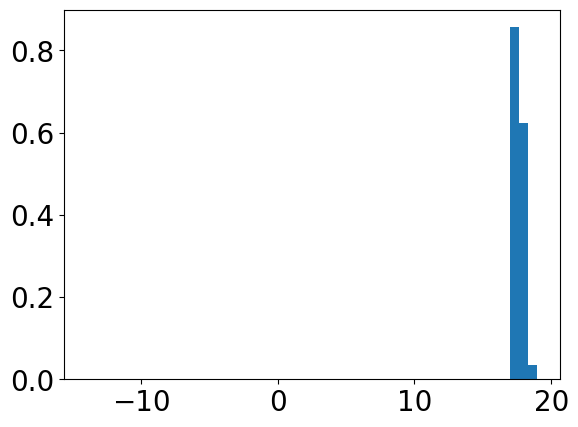

In [11]:
plt.hist(np.log10(np.exp(meta_list[:, 11])),  bins=50, density=True);

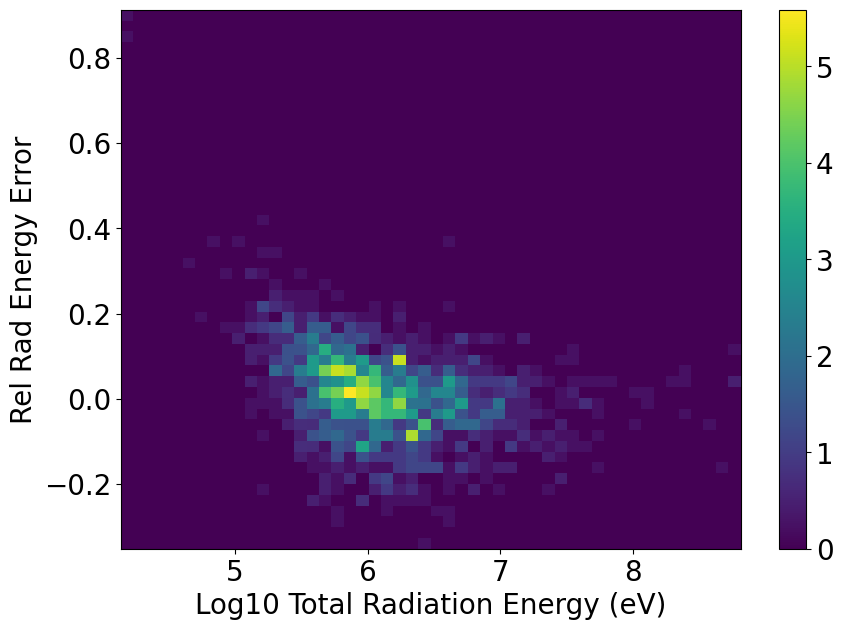

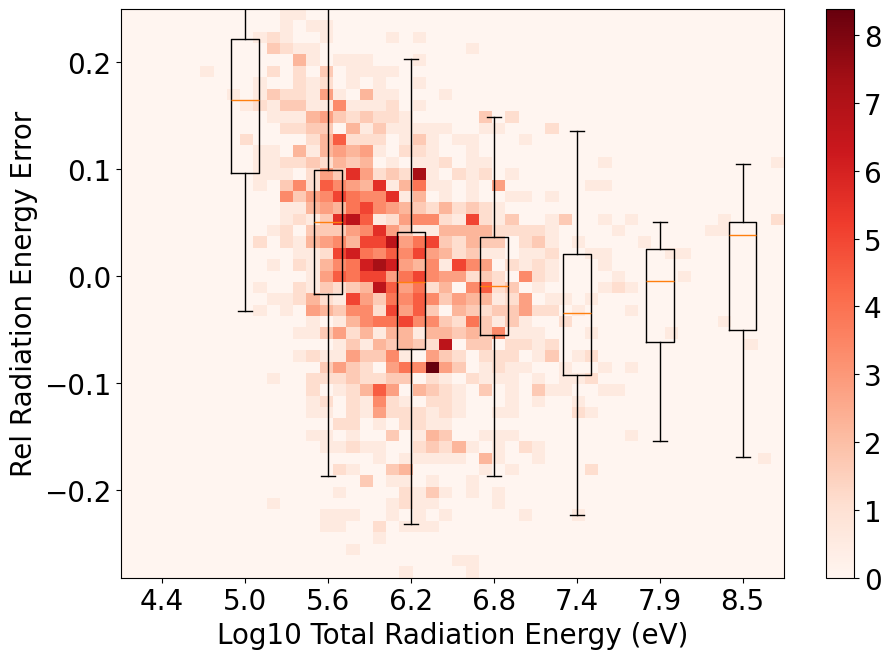

[ 0.69935774  0.15676677  0.04028659 -0.01358918 -0.01613384 -0.03389936
 -0.02621103 -0.00329902]
(3, 8)
(8,)


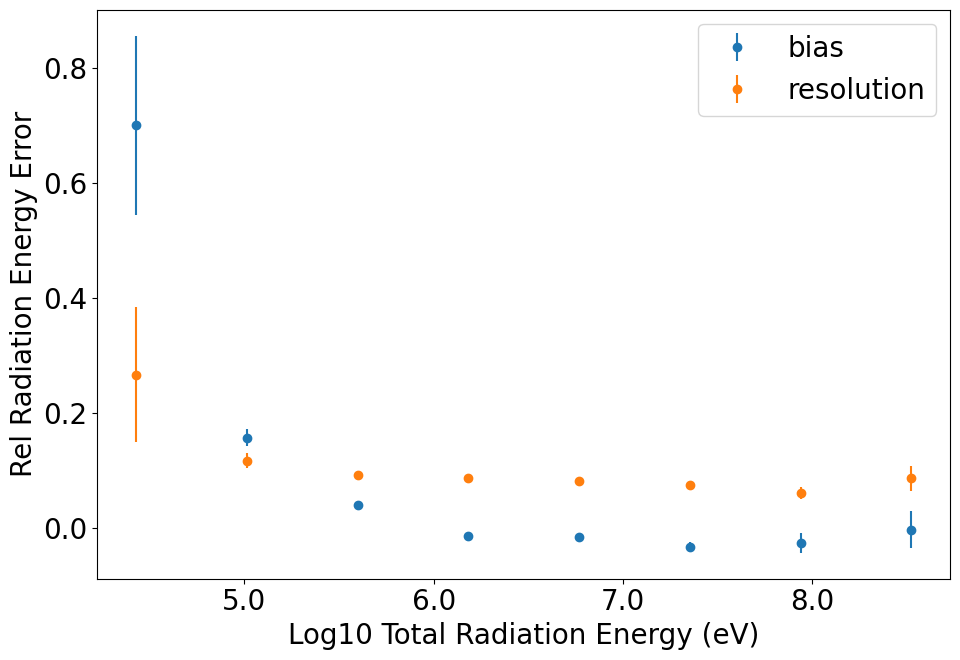

In [12]:
index = np.argwhere(np.isfinite(rad_energy[:,0]) & (rad_energy[:,0] > 0) & (meta_list[:, 2] < 1000/700)).flatten() 
x_meta = np.log10(rad_energy[index,0])
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]
plt.figure(figsize=(10,7))
h=plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('Log10 Total Radiation Energy (eV)')
plt.ylabel('Rel Rad Energy Error')
box_hist(x_meta,raderr, xlabel='Log10 Total Radiation Energy (eV)', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr, xlabel='Log10 Total Radiation Energy (eV)', ylabel='Rel Radiation Energy Error')

In [13]:
i

1999

[-0.99755448  0.         -7.39446731 -2.44788634 -0.94551068 -3.23236004
  6.03237159  0.22798123  1.85070402 -1.02265923 -0.46205165  0.99914006
 -0.05102796  0.72145109  1.15983698  3.26577507]
(3, 16)
(16,)


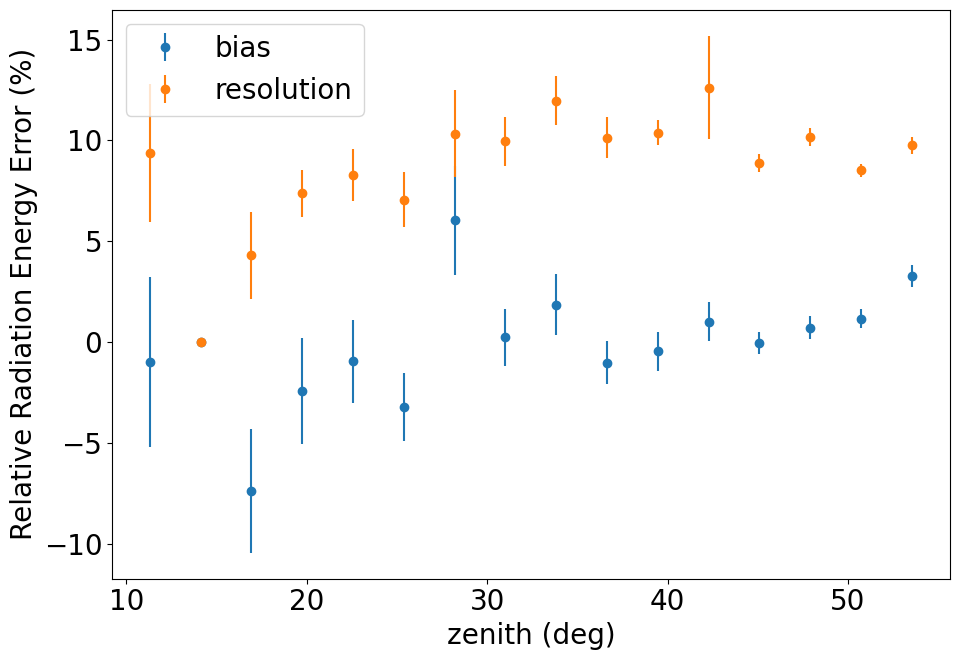

In [27]:
x_meta = np.rad2deg(np.arccos(meta_list[index, 1]))
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]
#plt.figure(figsize=(10,7))
#h=plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
#plt.colorbar(h[3], ax=plt.gca())
#plt.xlabel('zenith')
#plt.ylabel('Rel Rad Energy Error')
#box_hist(x_meta,raderr, xlabel='zenith', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr*100, xlabel=r'zenith (deg)', ylabel='Relative Radiation Energy Error (%)', bins=16)
plt.savefig('rad_energy_zenith.pdf', format='pdf')

[-0.33281663  0.83904295  1.62419734 -1.46808624 -2.81455997  1.38904534
  3.81936718  5.01671258]
(3, 8)
(8,)


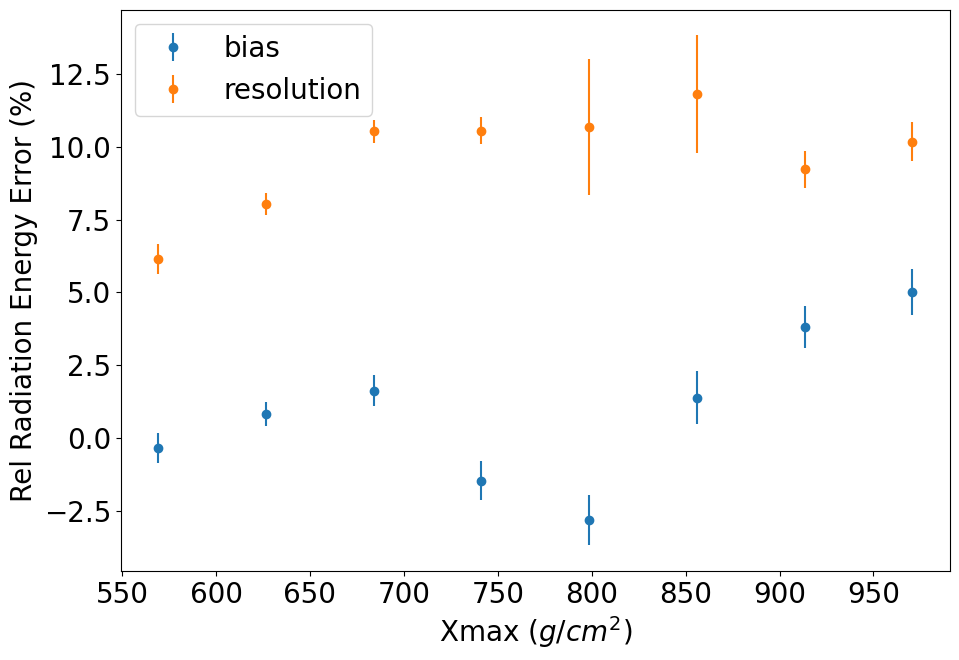

In [29]:
x_meta = meta_list[index, 2]*700
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]

#plt.figure(figsize=(10,7))
#h = plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
#plt.colorbar(h[3], ax=plt.gca())
#plt.xlabel('Xmax')
#plt.ylabel('Rel Rad Energy Error')
#box_hist(x_meta,raderr, xlabel='Xmax', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr*100, xlabel=r'Xmax $(g/cm^2)$', ylabel='Rel Radiation Energy Error (%)')
plt.savefig('rad_energy_xmax.pdf', format='pdf')

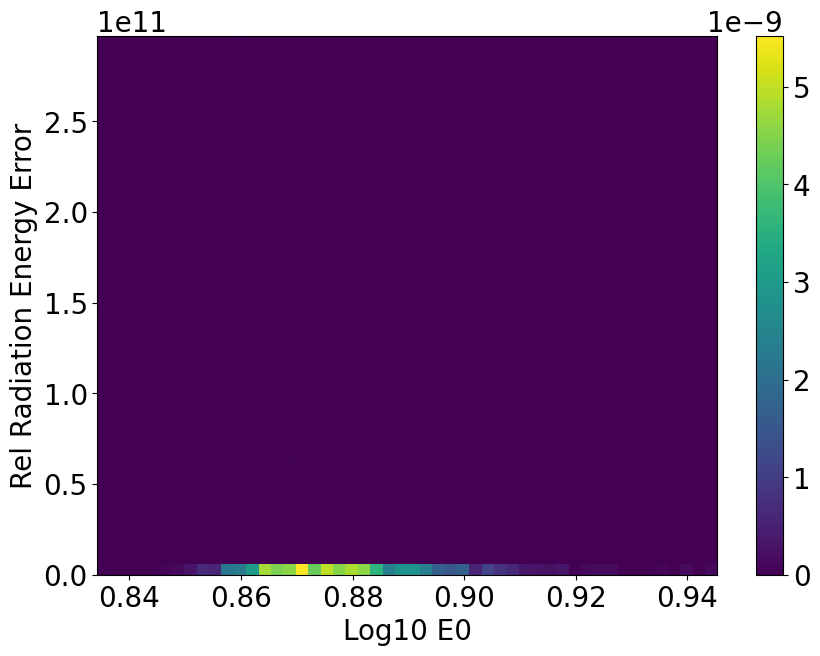

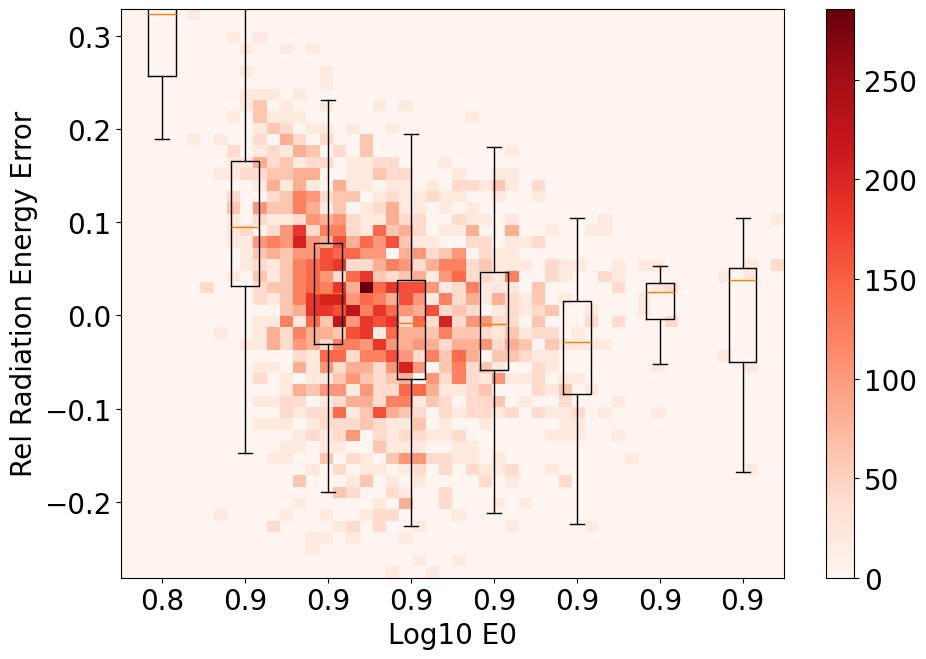

[ 1.60875223e+00  1.68781122e+09  8.69239930e+07  8.90492430e+01
 -6.54471918e-03 -3.28799987e-02  2.59854944e-03 -3.29901805e-03]
(3, 8)
(8,)


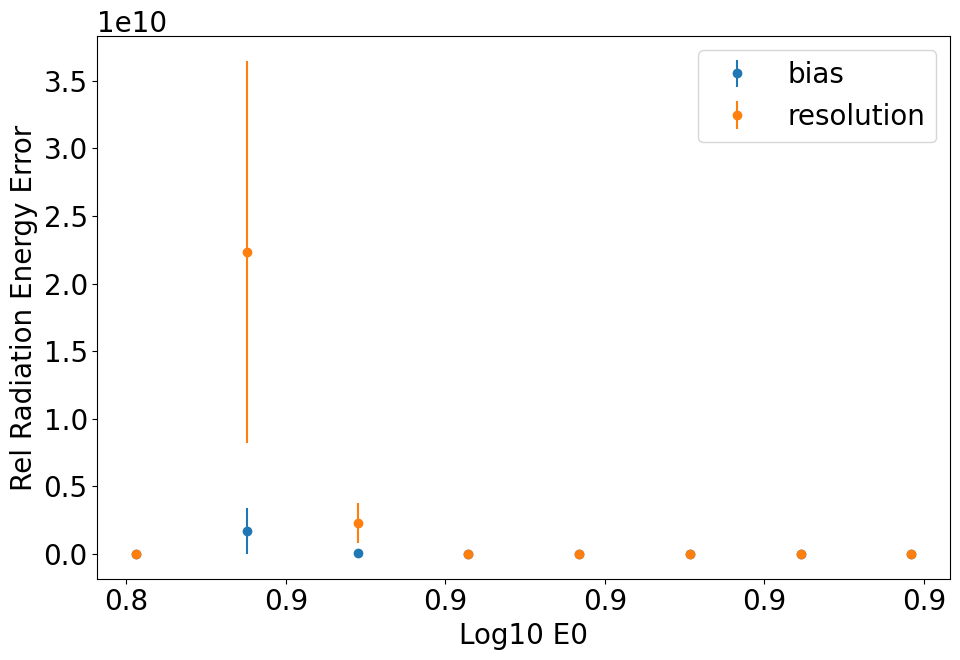

In [16]:
x_meta = np.log10(np.exp(meta_list[index, 5]))
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
plt.figure(figsize=(10,7))
h = plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
plt.colorbar(h[3], ax=plt.gca())
plt.ylabel('Rel Radiation Energy Error')
plt.xlabel('Log10 E0')
box_hist(x_meta,raderr, xlabel='Log10 E0', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr, xlabel='Log10 E0', ylabel='Rel Radiation Energy Error')

Text(0.5, 0, 'E_em')

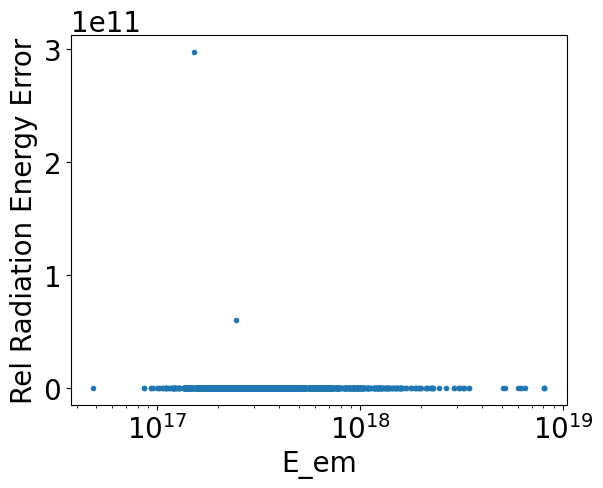

In [17]:
plt.scatter(np.exp(meta_list[index, 5]*20),(rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0], marker='.')
plt.xscale('log')
plt.ylabel('Rel Radiation Energy Error')
plt.xlabel('E_em')
